# Demo RNA Multi-Perceptrón Backpropagation para clasificar (atributo clase discreto) o estimar (atributo clase continuo)

In [1]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import csv

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random

from model.loader import CustomDataset
from model.model import Model
from model.trainer import train_model
from torch.utils.data import DataLoader
from analysis.logger import Logger
from model.LinearClamp import LinearClamp

import torch
import torch.optim as optim
import torch.nn as nn

print("Librerías cargadas")

2025-11-21 14:02:53.226500: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 14:02:53.414806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 14:02:56.543603: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Librerías cargadas


## Pre-procesamiento de datos

In [2]:
!wget https://raw.githubusercontent.com/juanfra18/TP-IAA/main/datos/Resilience_CleanOnly_v1.csv -O Resilience_CleanOnly_v1.csv

--2025-11-21 14:03:00--  https://raw.githubusercontent.com/juanfra18/TP-IAA/main/datos/Resilience_CleanOnly_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1402236 (1,3M) [application/octet-stream]
Saving to: ‘Resilience_CleanOnly_v1.csv’

Resilience_CleanOnl 100%[===================>]   1,34M  --.-KB/s    in 0,1s    

2025-11-21 14:03:00 (12,6 MB/s) - ‘Resilience_CleanOnly_v1.csv’ saved [1402236/1402236]



In [3]:
original_data = pd.read_csv('datos/Resilience_CleanOnly_v1.csv', encoding='cp1252', delimiter=',')
original_data.head()

,ppt_internal_id,Dataset,r8.2_who5_num,r8.2_who5_fct4,r8.2_who5_Iexcel,age_fct6,gender_fct2,eth_fct4,education_qual,r4_previnworkforce_fct3,...,r8.16_2_fct2,r8.16_3_fct2,r8.16_6_fct2,r8.16_4_fct2,r12.1_11_fct2,r12.1_13_fct2,r6.4_fct2,r6.5_fct2,r6_change_fct3,postweight_unscaled
0,1,Dynata,13,Good,Other,15-24,Male,European/Other^,High school,Employed,...,No,No,No,No,No,Yes,Low level,Low level,Increase,3402.795918
1,2,Dynata,21,Very good,Other,55-64,Male,European/Other^,Certificate or diploma,Retired,...,No,No,No,No,Yes,No,Hazardous level,Hazardous level,No change,2250.293478
2,3,Dynata,16,Good,Other,25-34,Female,Pacific,Bachelor or above,Employed,...,No,No,Yes,No,No,No,Low level,Low level,No change,1659.857143
3,4,Dynata,4,Poor,Other,45-54,Female,European/Other^,Bachelor or above,Employed,...,Yes,No,No,Yes,Yes,No,Low level,Low level,Increase,2132.097087
4,5,Dynata,7,Poor,Other,15-24,Female,European/Other^,Certificate or diploma,Employed,...,Yes,Yes,Yes,Yes,Yes,Yes,Low level,Low level,Increase,2008.063291


In [4]:
original_data

,ppt_internal_id,Dataset,r8.2_who5_num,r8.2_who5_fct4,r8.2_who5_Iexcel,age_fct6,gender_fct2,eth_fct4,education_qual,r4_previnworkforce_fct3,...,r8.16_2_fct2,r8.16_3_fct2,r8.16_6_fct2,r8.16_4_fct2,r12.1_11_fct2,r12.1_13_fct2,r6.4_fct2,r6.5_fct2,r6_change_fct3,postweight_unscaled
0,1,Dynata,13,Good,Other,15-24,Male,European/Other^,High school,Employed,...,No,No,No,No,No,Yes,Low level,Low level,Increase,3402.795918
1,2,Dynata,21,Very good,Other,55-64,Male,European/Other^,Certificate or diploma,Retired,...,No,No,No,No,Yes,No,Hazardous level,Hazardous level,No change,2250.293478
2,3,Dynata,16,Good,Other,25-34,Female,Pacific,Bachelor or above,Employed,...,No,No,Yes,No,No,No,Low level,Low level,No change,1659.857143
3,4,Dynata,4,Poor,Other,45-54,Female,European/Other^,Bachelor or above,Employed,...,Yes,No,No,Yes,Yes,No,Low level,Low level,Increase,2132.097087
4,5,Dynata,7,Poor,Other,15-24,Female,European/Other^,Certificate or diploma,Employed,...,Yes,Yes,Yes,Yes,Yes,Yes,Low level,Low level,Increase,2008.063291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,3483,Ministries,20,Very good,Other,65+,Female,Pacific,No formal qualification,Employed,...,No,No,No,Yes,Yes,Yes,Low level,Low level,No change,2661.000000
3483,3484,Ministries,6,Poor,Other,45-54,Male,Maori,No formal qualification,Employed,...,No,No,No,No,No,No,Low level,Low level,No change,2315.666667
3484,3485,Ministries,7,Poor,Other,25-34,Male,European/Other^,Certificate or diploma,Employed,...,No,Yes,No,Yes,Yes,Yes,Low level,Low level,No change,4053.000000
3485,3486,Ministries,10,Poor,Other,45-54,Female,European/Other^,High school,Employed,...,No,No,No,No,Yes,No,Low level,Low level,No change,1557.489362


In [5]:
original_data[['r3.3_fct5','r3.3_num']]
#Prefiero quedarme con r3.3_fct5 ya que es más facil luego encontrar patrones entre los datos si están categorizados y no tienen valores sueltos. sin embargo, la segunda variable no tiene valores nulos mientras que la primera si, asi q la transformo luego

#Quito r3.3_num, r8.2_who5_fct4, r8.2_who5_Iexcel, r3.3_num
#postweight_unscaled no es propiedad real del caso, tal vez pueden usarse como pesos para el entrenamiento¿?

,r3.3_fct5,r3.3_num
0,6-9,6
1,2,2
2,3-5,3
3,3-5,4
4,1,1
...,...,...
3482,2,2
3483,3-5,5
3484,3-5,3
3485,3-5,3


In [6]:
original_data[['postweight_unscaled']]

,postweight_unscaled
0,3402.795918
1,2250.293478
2,1659.857143
3,2132.097087
4,2008.063291
...,...
3482,2661.000000
3483,2315.666667
3484,4053.000000
3485,1557.489362


In [7]:
rename_col = {
    'r8.2_who5_num': 'target',

    'age_fct6': 'age_group',
    'gender_fct2': 'gender',
    'eth_fct4': 'ethnicity',
    'r4_previnworkforce_fct3': 'employment_pre_lockdown',
    'r4.5_fct3': 'work_type',
    'r7.1_fct3': 'smoking_status',
    'r5.2_fct2': 'self_rated_health',
    'r8.17_fct2': 'mental_health_diagnosis',
    'r5.10': 'physical_disability',
    'r9.1_fct2': 'trauma_exposure',
    'r3.2_fct4': 'bubble_type',
  # 'r3.3_fct5': 'bubble_size_cat',
    'r3.3_num': 'bubble_size_num',
    'r3.7_fct3': 'social_connection_freq',
    'r3.8': 'contact_change',
    'r4_lesswork_fct2': 'less_work',
    'r4_lostwork_fct2': 'lost_work',
    'r5.6_fct3': 'covid_exposure',
    'r3.4': 'bubble_satisfaction',
    'r3.10': 'bubble_relationships',
    'r3.11': 'loneliness',
    'r3.12': 'time_covid_info',
    'r8.16_1_fct2': 'stress_self_health',
    'r8.16_2_fct2': 'stress_family_health',
    'r8.16_3_fct2': 'stress_finances',
    'r8.16_6_fct2': 'stress_employment',
    'r8.16_4_fct2': 'stress_covid_conseq',
    'r12.1_11_fct2': 'positive_lockdown_personal',
    'r12.1_13_fct2': 'positive_lockdown_society',
    'r6.4_fct2': 'alcohol_pre',
    'r6.5_fct2': 'alcohol_during',
    'r6_change_fct3': 'alcohol_change',
}

In [8]:
data = original_data.copy()

In [9]:
data = data.drop(columns=['r3.3_fct5', 'r8.2_who5_fct4', 'r8.2_who5_Iexcel','postweight_unscaled','ppt_internal_id','Dataset'])

In [10]:
data = data.rename(columns = rename_col)

In [11]:
data.shape

(3487, 34)

# Missing values

## Total missing values

In [12]:
(data.isnull().sum().sort_values(ascending=False)/len(data))*100

lost_work                     45.081732
loneliness                    42.299971
less_work                     39.116719
work_type                     39.088041
bubble_relationships          15.256668
mental_health_diagnosis        2.208202
social_connection_freq         2.122168
gender                         0.630915
contact_change                 0.573559
positive_lockdown_personal     0.458847
positive_lockdown_society      0.458847
income_band                    0.401491
alcohol_change                 0.229424
alcohol_during                 0.200746
alcohol_pre                    0.143390
bubble_type                    0.114712
time_covid_info                0.086034
smoking_status                 0.086034
employment_pre_lockdown        0.028678
covid_exposure                 0.028678
age_group                      0.000000
target                         0.000000
education_qual                 0.000000
ethnicity                      0.000000
physical_disability            0.000000


In [13]:
data.isnull().sum().sort_values(ascending=False)

lost_work                     1572
loneliness                    1475
less_work                     1364
work_type                     1363
bubble_relationships           532
mental_health_diagnosis         77
social_connection_freq          74
gender                          22
contact_change                  20
positive_lockdown_personal      16
positive_lockdown_society       16
income_band                     14
alcohol_change                   8
alcohol_during                   7
alcohol_pre                      5
bubble_type                      4
time_covid_info                  3
smoking_status                   3
employment_pre_lockdown          1
covid_exposure                   1
age_group                        0
target                           0
education_qual                   0
ethnicity                        0
physical_disability              0
self_rated_health                0
bubble_size_num                  0
trauma_exposure                  0
bubble_satisfaction 

## target

In [14]:
data['target'].value_counts(dropna=False)

target
20    337
19    274
17    236
18    223
15    219
16    207
14    198
13    182
21    150
12    143
10    142
9     132
11    128
5     125
22    102
8      98
6      97
7      92
25     85
4      70
3      62
23     62
24     54
2      24
.      19
1      14
0      12
Name: count, dtype: int64

In [15]:
# Mantener solo valores numéricos <= 25 y distintos de '.'
col = pd.to_numeric(
    data['target'].astype(str).str.strip().replace({'.': np.nan, '': np.nan}),
    errors='coerce'
)
data = data[col.le(25)].copy()  # descarta NaN y >25
data['target'] = col.loc[data.index].astype('Int64')
data['target'].value_counts(dropna=False)

target
20    337
19    274
17    236
18    223
15    219
16    207
14    198
13    182
21    150
12    143
10    142
9     132
11    128
5     125
22    102
8      98
6      97
7      92
25     85
4      70
3      62
23     62
24     54
2      24
1      14
0      12
Name: count, dtype: Int64

## employment_pre_lockdown

In [16]:
table = 'employment_pre_lockdown'
data[table].value_counts(dropna=False)

employment_pre_lockdown
Employed      2230
Retired        661
Unemployed     576
NaN              1
Name: count, dtype: int64

In [17]:
most_common = data[table].value_counts(dropna=False).idxmax()
data[table] = np.where(data[table].isnull(), most_common, data[table])
data[table].value_counts(dropna=False)

employment_pre_lockdown
Employed      2231
Retired        661
Unemployed     576
Name: count, dtype: int64

## bubble_type

In [18]:
table = 'bubble_type'
data[table].value_counts(dropna=False)

bubble_type
With children        1149
With one adult       1103
With other adults     685
Live by myself        527
NaN                     4
Name: count, dtype: int64

In [19]:
most_common = data[table].value_counts(dropna=False).idxmax()
data[table] = np.where(data[table].isnull(), most_common, data[table])
data[table].value_counts(dropna=False)

bubble_type
With children        1153
With one adult       1103
With other adults     685
Live by myself        527
Name: count, dtype: int64

## lost_work

In [20]:
data['lost_work'].value_counts(dropna=False)

lost_work
Not lost work    1797
NaN              1559
Lost work         112
Name: count, dtype: int64

In [21]:
(data['employment_pre_lockdown']!='Employed').sum()
#Quienes directamente no tenían trabajo previo al COVID no pueden perderlo

1237

In [22]:
data['lost_work'] = np.where(data['lost_work'].isnull() & (data['employment_pre_lockdown']!='Employed'), 'Without work', data['lost_work'])
data['lost_work'].value_counts()

lost_work
Not lost work    1797
Without work     1237
Lost work         112
Name: count, dtype: int64

In [23]:
nulos = data['lost_work'].isnull().sum()
print('Porcentaje de nulos: ', (nulos/len(data))*100)
print('Cantidad de nulos: ', nulos)

Porcentaje de nulos:  9.284890426758938
Cantidad de nulos:  322


In [24]:
data['lost_work'] = np.where(data['lost_work'].isnull(), 'Not lost work', data['lost_work'])

## loneliness

In [25]:
data[['loneliness']].value_counts()
#Los nulos en realidad corresponden a la categoría 'none'

loneliness        
More than a little    1003
A little               996
Name: count, dtype: int64

In [26]:
data['loneliness'] = np.where(data['loneliness'].isnull(), 'None', data['loneliness'])
data[['loneliness']].value_counts()

loneliness        
None                  1469
More than a little    1003
A little               996
Name: count, dtype: int64

## less_work

In [27]:
#Caso similar a lost_work

In [28]:
data['less_work'].value_counts()

less_work
Not less work    1348
Less work         769
Name: count, dtype: int64

In [29]:
data['less_work'] = np.where(data['less_work'].isnull() & (data['employment_pre_lockdown']!='Employed'), 'Without work', data['less_work'])
data['less_work'].value_counts()

less_work
Not less work    1348
Without work     1237
Less work         769
Name: count, dtype: int64

In [30]:
nulos = data['less_work'].isnull().sum()
print('Porcentaje de nulos: ', (nulos/len(data))*100)
print('Cantidad de nulos: ', nulos)

Porcentaje de nulos:  3.2871972318339098
Cantidad de nulos:  114


In [31]:
data['less_work'] = np.where(data['less_work'].isnull(), 'Not less work', data['less_work'])

## work_type


In [32]:
data['work_type'].value_counts(dropna=False)

work_type
Not essential worker    1395
NaN                     1350
Yes essential worker     723
Name: count, dtype: int64

In [33]:
data['work_type'] = np.where(data['work_type'].isnull() & (data['employment_pre_lockdown']!='Employed'), 'Without work', data['work_type'])
data['work_type'].value_counts(dropna=False)

work_type
Not essential worker    1395
Without work            1237
Yes essential worker     723
NaN                      113
Name: count, dtype: int64

In [34]:
nulos = data['work_type'].isnull().sum()
print('Porcentaje de nulos: ', (nulos/len(data))*100)
print('Cantidad de nulos: ', nulos)

Porcentaje de nulos:  3.2583621683967703
Cantidad de nulos:  113


In [35]:
data['work_type'] = np.where(data['work_type'].isnull(), 'Not essential worker', data['work_type'])

In [36]:
data['work_type'].value_counts(dropna=False)

work_type
Not essential worker    1508
Without work            1237
Yes essential worker     723
Name: count, dtype: int64

## bubble_size_num
Hago que sea 0 cuando no tiene bubble

In [37]:
data['bubble_size_num'].value_counts(dropna=False)

bubble_size_num
2      1176
3       617
4       574
1       527
5       320
6       118
7        56
8        26
9        15
.         9
10        8
12        5
13        4
11        4
25        1
14        1
19        1
40        1
21        1
45        1
999       1
15        1
70        1
Name: count, dtype: int64

In [38]:
# Mantener solo valores numéricos <= 50 y distintos de '.'
col = pd.to_numeric(
    data['bubble_size_num'].astype(str).str.strip().replace({'.': np.nan, '': np.nan}),
    errors='coerce'
)
data = data[col.le(50)].copy()  # descarta NaN y >50
data['bubble_size_num'] = col.loc[data.index].astype('Int64')
data['bubble_size_num'].value_counts(dropna=False)

bubble_size_num
2     1176
3      617
4      574
1      527
5      320
6      118
7       56
8       26
9       15
10       8
12       5
13       4
11       4
25       1
14       1
19       1
40       1
21       1
45       1
15       1
Name: count, dtype: Int64

## bubble_relationships

In [39]:
data['bubble_relationships'].value_counts(dropna=False)

bubble_relationships
Very well    1335
Well         1114
NaN           528
Not well      480
Name: count, dtype: int64

In [40]:
# Aquellos que viven solos no van a tener asociado bubble_relationships
len(data[data['bubble_relationships'].isnull() & (data['bubble_type']=='Live by myself')])

527

In [41]:
data['bubble_relationships'] = np.where(data['bubble_relationships'].isnull() & (data['bubble_type']=='Live by myself'), 'Without bubble', data['bubble_relationships'])
data['bubble_relationships'].value_counts(dropna=False)

bubble_relationships
Very well         1335
Well              1114
Without bubble     527
Not well           480
NaN                  1
Name: count, dtype: int64

In [42]:
data['bubble_relationships'] = np.where(data['bubble_relationships'].isnull(), 'Very well', data['bubble_relationships'])
data['bubble_relationships'].value_counts(dropna=False)

bubble_relationships
Very well         1336
Well              1114
Without bubble     527
Not well           480
Name: count, dtype: int64

## mental_health_diagnosis


In [43]:
data['mental_health_diagnosis'].value_counts(dropna=False)

mental_health_diagnosis
No                    2755
Yes past diagnosis     627
NaN                     75
Name: count, dtype: int64

In [44]:
nulos = data['mental_health_diagnosis'].isnull().sum()
print('Porcentaje de nulos: ', (nulos/len(data))*100)
print('Cantidad de nulos: ', nulos)

Porcentaje de nulos:  2.169511136823836
Cantidad de nulos:  75


In [45]:
data['mental_health_diagnosis'] = np.where(data['mental_health_diagnosis'].isnull(), 'No', data['mental_health_diagnosis'])
data['mental_health_diagnosis'].value_counts(dropna=False)

mental_health_diagnosis
No                    2830
Yes past diagnosis     627
Name: count, dtype: int64

## social_connection_freq


In [46]:
data['social_connection_freq'].value_counts(dropna=False)

social_connection_freq
High      1995
Medium     944
Low        447
NaN         71
Name: count, dtype: int64

In [47]:
nulos = data['social_connection_freq'].isnull().sum()
print('Porcentaje de nulos: ', (nulos/len(data))*100)
print('Cantidad de nulos: ', nulos)

Porcentaje de nulos:  2.053803876193231
Cantidad de nulos:  71


In [48]:
data['social_connection_freq'] = np.where(data['social_connection_freq'].isnull(), 'High', data['social_connection_freq'])
data['social_connection_freq'].value_counts(dropna=False)

social_connection_freq
High      2066
Medium     944
Low        447
Name: count, dtype: int64

## gender


In [49]:
data['gender'].value_counts(dropna=False)

gender
Female    1961
Male      1474
NaN         22
Name: count, dtype: int64

In [50]:
data['gender'] = np.where(data['gender'].isnull(), 'Female', data['gender'])
data['gender'].value_counts(dropna=False)

gender
Female    1983
Male      1474
Name: count, dtype: int64

## contact_change


In [51]:
data['contact_change'].value_counts(dropna=False)

contact_change
It has stayed the same    1231
It has increased          1117
It has decreased          1091
NaN                         18
Name: count, dtype: int64

In [52]:
data['contact_change'] = np.where(data['contact_change'].isnull(), 'It has stayed the same', data['contact_change'])
data['contact_change'].value_counts(dropna=False)

contact_change
It has stayed the same    1249
It has increased          1117
It has decreased          1091
Name: count, dtype: int64

## positive_lockdown_personal


In [53]:
data['positive_lockdown_personal'].value_counts(dropna=False)

positive_lockdown_personal
No     1741
Yes    1700
NaN      16
Name: count, dtype: int64

In [54]:
data['positive_lockdown_personal'] = np.where(data['positive_lockdown_personal'].isnull(), 'No', data['positive_lockdown_personal'])
data['positive_lockdown_personal'].value_counts(dropna=False)

positive_lockdown_personal
No     1757
Yes    1700
Name: count, dtype: int64

## positive_lockdown_society


In [55]:
data['positive_lockdown_society'].value_counts(dropna=False)

positive_lockdown_society
No     2003
Yes    1438
NaN      16
Name: count, dtype: int64

In [56]:
data['positive_lockdown_society'] = np.where(data['positive_lockdown_society'].isnull(), 'No', data['positive_lockdown_society'])
data['positive_lockdown_society'].value_counts(dropna=False)

positive_lockdown_society
No     2019
Yes    1438
Name: count, dtype: int64

## income_band


In [57]:
data['income_band'].value_counts(dropna=False)

income_band
$30,001– $70,000       1173
$30,000 or less        1114
$70,001 – $100,000      432
Prefer not to say       360
$100,001 – $150,000     238
$150,001 or more        126
NaN                      14
Name: count, dtype: int64

In [58]:
most_common = data['income_band'].value_counts(dropna=False).idxmax()
data['income_band'] = np.where(data['income_band'].isnull(), most_common, data['income_band'])
data['income_band'].value_counts(dropna=False)

income_band
$30,001– $70,000       1187
$30,000 or less        1114
$70,001 – $100,000      432
Prefer not to say       360
$100,001 – $150,000     238
$150,001 or more        126
Name: count, dtype: int64

## alcohol_change


In [59]:
data['alcohol_change'].value_counts(dropna=False)

alcohol_change
No change    1976
Increase      870
Decrease      603
NaN             8
Name: count, dtype: int64

In [60]:
data['alcohol_change'] = np.where(data['alcohol_change'].isnull(), 'No change', data['alcohol_change'])
data['alcohol_change'].value_counts(dropna=False)

alcohol_change
No change    1984
Increase      870
Decrease      603
Name: count, dtype: int64

## alcohol_during

In [61]:
data['alcohol_during'].value_counts(dropna=False)

alcohol_during
Low level          3017
Hazardous level     433
NaN                   7
Name: count, dtype: int64

In [62]:
data['alcohol_during'] = np.where(data['alcohol_during'].isnull(), 'Low level', data['alcohol_during'])
data['alcohol_during'].value_counts(dropna=False)

alcohol_during
Low level          3024
Hazardous level     433
Name: count, dtype: int64

## alcohol_pre

In [63]:
table = 'alcohol_pre'
data[table].value_counts(dropna=False)

alcohol_pre
Low level          3103
Hazardous level     349
NaN                   5
Name: count, dtype: int64

In [64]:
most_common = data[table].value_counts(dropna=False).idxmax()
data[table] = np.where(data[table].isnull(), most_common, data[table])
data[table].value_counts(dropna=False)

alcohol_pre
Low level          3108
Hazardous level     349
Name: count, dtype: int64

## time_covid_info

In [65]:
table = 'time_covid_info'
data[table].value_counts(dropna=False)

time_covid_info
Less than 2 hours    2975
Two plus hours        479
NaN                     3
Name: count, dtype: int64

In [66]:
most_common = data[table].value_counts(dropna=False).idxmax()
data[table] = np.where(data[table].isnull(), most_common, data[table])
data[table].value_counts(dropna=False)

time_covid_info
Less than 2 hours    2978
Two plus hours        479
Name: count, dtype: int64

## smoking_status

In [67]:
table = 'smoking_status'
data[table].value_counts(dropna=False)

smoking_status
Never      1868
Past       1043
Current     543
NaN           3
Name: count, dtype: int64

In [68]:
most_common = data[table].value_counts(dropna=False).idxmax()
data[table] = np.where(data[table].isnull(), most_common, data[table])
data[table].value_counts(dropna=False)

smoking_status
Never      1871
Past       1043
Current     543
Name: count, dtype: int64

## covid_exposure

In [69]:
table = 'covid_exposure'
data[table].value_counts(dropna=False)

covid_exposure
No           3299
Tested        119
Suspected      28
Confirmed      10
NaN             1
Name: count, dtype: int64

In [70]:
most_common = data[table].value_counts(dropna=False).idxmax()
data[table] = np.where(data[table].isnull(), most_common, data[table])
data[table].value_counts(dropna=False)

covid_exposure
No           3300
Tested        119
Suspected      28
Confirmed      10
Name: count, dtype: int64

In [71]:
data.isnull().sum().sort_values(ascending=False)

target                        0
age_group                     0
gender                        0
ethnicity                     0
education_qual                0
employment_pre_lockdown       0
work_type                     0
smoking_status                0
income_band                   0
self_rated_health             0
mental_health_diagnosis       0
physical_disability           0
trauma_exposure               0
bubble_type                   0
bubble_size_num               0
social_connection_freq        0
contact_change                0
less_work                     0
lost_work                     0
covid_exposure                0
bubble_satisfaction           0
bubble_relationships          0
loneliness                    0
time_covid_info               0
stress_self_health            0
stress_family_health          0
stress_finances               0
stress_employment             0
stress_covid_conseq           0
positive_lockdown_personal    0
positive_lockdown_society     0
alcohol_

In [72]:
data

,target,age_group,gender,ethnicity,education_qual,employment_pre_lockdown,work_type,smoking_status,income_band,self_rated_health,...,stress_self_health,stress_family_health,stress_finances,stress_employment,stress_covid_conseq,positive_lockdown_personal,positive_lockdown_society,alcohol_pre,alcohol_during,alcohol_change
0,13,15-24,Male,European/Other^,High school,Employed,Yes essential worker,Never,"$30,000 or less",Good or better,...,No,No,No,No,No,No,Yes,Low level,Low level,Increase
1,21,55-64,Male,European/Other^,Certificate or diploma,Retired,Without work,Never,"$70,001 – $100,000",Good or better,...,Yes,No,No,No,No,Yes,No,Hazardous level,Hazardous level,No change
2,16,25-34,Female,Pacific,Bachelor or above,Employed,Yes essential worker,Current,"$30,001– $70,000",Poor or Fair,...,No,No,No,Yes,No,No,No,Low level,Low level,No change
3,4,45-54,Female,European/Other^,Bachelor or above,Employed,Yes essential worker,Never,"$30,000 or less",Good or better,...,No,Yes,No,No,Yes,Yes,No,Low level,Low level,Increase
4,7,15-24,Female,European/Other^,Certificate or diploma,Employed,Not essential worker,Past,"$30,001– $70,000",Good or better,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Low level,Low level,Increase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,20,65+,Female,Pacific,No formal qualification,Employed,Not essential worker,Past,"$100,001 – $150,000",Good or better,...,No,No,No,No,Yes,Yes,Yes,Low level,Low level,No change
3483,6,45-54,Male,Maori,No formal qualification,Employed,Yes essential worker,Past,"$70,001 – $100,000",Good or better,...,No,No,No,No,No,No,No,Low level,Low level,No change
3484,7,25-34,Male,European/Other^,Certificate or diploma,Employed,Not essential worker,Never,"$30,001– $70,000",Good or better,...,No,No,Yes,No,Yes,Yes,Yes,Low level,Low level,No change
3485,10,45-54,Female,European/Other^,High school,Employed,Not essential worker,Never,"$70,001 – $100,000",Good or better,...,No,No,No,No,No,Yes,No,Low level,Low level,No change


# Normalización de datos:

In [73]:
data.head()

,target,age_group,gender,ethnicity,education_qual,employment_pre_lockdown,work_type,smoking_status,income_band,self_rated_health,...,stress_self_health,stress_family_health,stress_finances,stress_employment,stress_covid_conseq,positive_lockdown_personal,positive_lockdown_society,alcohol_pre,alcohol_during,alcohol_change
0,13,15-24,Male,European/Other^,High school,Employed,Yes essential worker,Never,"$30,000 or less",Good or better,...,No,No,No,No,No,No,Yes,Low level,Low level,Increase
1,21,55-64,Male,European/Other^,Certificate or diploma,Retired,Without work,Never,"$70,001 – $100,000",Good or better,...,Yes,No,No,No,No,Yes,No,Hazardous level,Hazardous level,No change
2,16,25-34,Female,Pacific,Bachelor or above,Employed,Yes essential worker,Current,"$30,001– $70,000",Poor or Fair,...,No,No,No,Yes,No,No,No,Low level,Low level,No change
3,4,45-54,Female,European/Other^,Bachelor or above,Employed,Yes essential worker,Never,"$30,000 or less",Good or better,...,No,Yes,No,No,Yes,Yes,No,Low level,Low level,Increase
4,7,15-24,Female,European/Other^,Certificate or diploma,Employed,Not essential worker,Past,"$30,001– $70,000",Good or better,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Low level,Low level,Increase


In [74]:
# Primero paso las columnas categóricas a números
mapping = {
        "age_group": {
            "15-24": 0,
            "25-34": 1,
            "35-44": 2,
            "45-54": 3,
            "55-64": 4,
            "65+": 5
        },
        "gender": {
            "Male": 0,
            "Female": 1
        },
        "ethnicity": {
            "European/Other^": 0,
            "Maori": 1,
            "Pacific": 2,
            "Asian": 3
        },
        "education_qual": {
            "No formal qualification": 0,
            "High school": 1,
            "Certificate or diploma": 2,
            "Bachelor or above": 3
        },
        "employment_pre_lockdown": {
            "Employed": 0,
            "Unemployed": 1,
            "Retired": 2
        },
        "work_type": {
            "Not essential worker": 0,
            "Yes essential worker": 1,
            "Without work": 2
        },
        "smoking_status": {
            "Never": 0,
            "Past": 1,
            "Current": 2
        },
        "income_band": {
            "$30,000 or less": 0,
            "$30,001– $70,000": 1,
            "$70,001 – $100,000": 2,
            "$100,001 – $150,000": 3,
            "$150,001 or more": 4,
            "Prefer not to say": 5
        },
        "self_rated_health": {
            "Poor or Fair": 0,
            "Good or better": 1
        },
        "mental_health_diagnosis": {
            "No": 0,
            "Yes past diagnosis": 1
        },
        "physical_disability": {
            "No": 0,
            "Yes": 1
        },
        "trauma_exposure": {
            "No": 0,
            "Yes": 1
        },
        "bubble_type": {
            "Live by myself": 0,
            "With one adult": 1,
            "With other adults": 2,
            "With children": 3
        },
        "social_connection_freq": {
            "High": 2,
            "Medium": 1,
            "Low": 0
        },
        "contact_change": {
            "It has stayed the same": 0,
            "It has increased": 1,
            "It has decreased": 2
        },
        "less_work": {
            "Not less work": 0,
            "Less work": 1,
            "Without work": 2
        },
        "lost_work": {
            "Not lost work": 0,
            "Lost work": 1,
            "Without work": 2
        },
        "covid_exposure": {
            "No": 0,
            "Suspected": 1,
            "Tested": 2,
            "Confirmed": 3
        },
        "bubble_satisfaction": {
            "Not satifisfied": 0,
            "Satisfied": 1,
            "Extremely satisfied": 2
        },
        "bubble_relationships": {
            "Not well": 0,
            "Well": 1,
            "Very well": 2,
            "Without bubble": 3
        },
        "loneliness": {
            "None": 0,
            "A little": 1,
            "More than a little": 2
        },
        "time_covid_info": {
            "Less than 2 hours": 0,
            "Two plus hours": 1
        },
        "stress_self_health": {
            "No": 0,
            "Yes": 1
        },
        "stress_family_health": {
            "No": 0,
            "Yes": 1
        },
        "stress_finances": {
            "No": 0,
            "Yes": 1
        },
        "stress_employment": {
            "No": 0,
            "Yes": 1
        },
        "stress_covid_conseq": {
            "No": 0,
            "Yes": 1
        },
        "positive_lockdown_personal": {
            "No": 0,
            "Yes": 1
        },
        "positive_lockdown_society": {
            "No": 0,
            "Yes": 1
        },
        "alcohol_pre": {
            "Low level": 0,
            "Hazardous level": 1
        },
        "alcohol_during": {
            "Low level": 0,
            "Hazardous level": 1
        },
        "alcohol_change": {
            "No change": 2,
            "Increase": 1,
            "Decrease": 0
        }
}

In [75]:
data_encoded = data.copy()

# 1) Reemplaza
data_encoded = data_encoded.replace(mapping)

# 2) Fuerza tipo numérico en las columnas mapeadas
for col, m in mapping.items():
    if col not in data_encoded.columns:
        continue
    if isinstance(m, dict) and len(m) == 0:
        # casos numéricos no codificados
        data_encoded[col] = pd.to_numeric(data_encoded[col], errors="coerce")
    elif isinstance(m, dict) and len(m) > 0:
        # columnas categóricas codificadas -> a enteros con soporte de NaN
        data_encoded[col] = pd.to_numeric(data_encoded[col], errors="coerce").astype("Int64")

# 3) (Opcional) chequeo de valores no mapeados
unmapped_report = {}
for col, m in mapping.items():
    if col in data.columns and isinstance(m, dict) and len(m) > 0:
        mask_unmapped = data[col].notna() & ~data[col].isin(m.keys())
        if mask_unmapped.any():
            unmapped_report[col] = sorted(data.loc[mask_unmapped, col].unique().tolist())

if unmapped_report:
    print("Categorías no mapeadas detectadas:", unmapped_report)

/tmp/ipykernel_561037/940831558.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data_encoded.replace(mapping)


In [76]:
data_encoded

,target,age_group,gender,ethnicity,education_qual,employment_pre_lockdown,work_type,smoking_status,income_band,self_rated_health,...,stress_self_health,stress_family_health,stress_finances,stress_employment,stress_covid_conseq,positive_lockdown_personal,positive_lockdown_society,alcohol_pre,alcohol_during,alcohol_change
0,13,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,21,4,0,0,2,2,2,0,2,1,...,1,0,0,0,0,1,0,1,1,2
2,16,1,1,2,3,0,1,2,1,0,...,0,0,0,1,0,0,0,0,0,2
3,4,3,1,0,3,0,1,0,0,1,...,0,1,0,0,1,1,0,0,0,1
4,7,0,1,0,2,0,0,1,1,1,...,1,1,1,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,20,5,1,2,0,0,0,1,3,1,...,0,0,0,0,1,1,1,0,0,2
3483,6,3,0,1,0,0,1,1,2,1,...,0,0,0,0,0,0,0,0,0,2
3484,7,1,0,0,2,0,0,0,1,1,...,0,0,1,0,1,1,1,0,0,2
3485,10,3,1,0,1,0,0,0,2,1,...,0,0,0,0,0,1,0,0,0,2


In [77]:
data_encoded.to_csv('datos/Resilience_CleanOnly_v1_PREPROCESSED_v2.csv', index=False)

# Definir y entrenar el modelo

In [78]:
#train_data = CustomDataset(train_df, feat_cols, 'target', scaler_X, scaler_y)
#val_data   = CustomDataset(val_df,   feat_cols, 'target', scaler_X, scaler_y)

#train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
#val_loader   = DataLoader(val_data, batch_size=256, shuffle=False)

[[2025-11-21 14:03:36]] Starting training on model: model_[33, 16, 1]_output_Identity_intermediate_ReLU_normalized_data_True_loss_MSELoss


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:03:40]] Epoch 1/300, Train Loss: 0.09846350, Val Loss: 0.04130050


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:03:43]] Epoch 2/300, Train Loss: 0.06661798, Val Loss: 0.03795769


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:03:46]] Epoch 3/300, Train Loss: 0.05693760, Val Loss: 0.03682591


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:03:49]] Epoch 4/300, Train Loss: 0.05220625, Val Loss: 0.03529586


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:03:52]] Epoch 5/300, Train Loss: 0.05007856, Val Loss: 0.03520442


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:03:55]] Epoch 6/300, Train Loss: 0.04535017, Val Loss: 0.03438099


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:03:59]] Epoch 7/300, Train Loss: 0.04529682, Val Loss: 0.03523970


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:02]] Epoch 8/300, Train Loss: 0.04403093, Val Loss: 0.03518446


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:05]] Epoch 9/300, Train Loss: 0.04216265, Val Loss: 0.03541332


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:08]] Epoch 10/300, Train Loss: 0.04184750, Val Loss: 0.03497852


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:12]] Epoch 11/300, Train Loss: 0.04112473, Val Loss: 0.03523385


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:15]] Epoch 12/300, Train Loss: 0.03991402, Val Loss: 0.03510929


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:18]] Epoch 13/300, Train Loss: 0.04008616, Val Loss: 0.03424631


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:21]] Epoch 14/300, Train Loss: 0.03926743, Val Loss: 0.03440705


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:24]] Epoch 15/300, Train Loss: 0.03904811, Val Loss: 0.03418254


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:27]] Epoch 16/300, Train Loss: 0.03907026, Val Loss: 0.03435572


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:31]] Epoch 17/300, Train Loss: 0.03829927, Val Loss: 0.03428346


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:35]] Epoch 18/300, Train Loss: 0.03808826, Val Loss: 0.03383354


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:39]] Epoch 19/300, Train Loss: 0.03883314, Val Loss: 0.03445940


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:42]] Epoch 20/300, Train Loss: 0.03805562, Val Loss: 0.03403182


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:46]] Epoch 21/300, Train Loss: 0.03758007, Val Loss: 0.03364258


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:50]] Epoch 22/300, Train Loss: 0.03881564, Val Loss: 0.03385469


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:53]] Epoch 23/300, Train Loss: 0.03814181, Val Loss: 0.03365821


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:04:56]] Epoch 24/300, Train Loss: 0.03796607, Val Loss: 0.03330621


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:00]] Epoch 25/300, Train Loss: 0.03745877, Val Loss: 0.03399407


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:04]] Epoch 26/300, Train Loss: 0.03663167, Val Loss: 0.03367144


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:12]] Epoch 27/300, Train Loss: 0.03698260, Val Loss: 0.03316774


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:19]] Epoch 28/300, Train Loss: 0.03661620, Val Loss: 0.03332059


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:22]] Epoch 29/300, Train Loss: 0.03670659, Val Loss: 0.03329044


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:25]] Epoch 30/300, Train Loss: 0.03738750, Val Loss: 0.03371431


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:28]] Epoch 31/300, Train Loss: 0.03713514, Val Loss: 0.03326209


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:32]] Epoch 32/300, Train Loss: 0.03616947, Val Loss: 0.03302846


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:35]] Epoch 33/300, Train Loss: 0.03753045, Val Loss: 0.03318180


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:38]] Epoch 34/300, Train Loss: 0.03536399, Val Loss: 0.03316971


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:42]] Epoch 35/300, Train Loss: 0.03684197, Val Loss: 0.03347116


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:46]] Epoch 36/300, Train Loss: 0.03669082, Val Loss: 0.03335387


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:53]] Epoch 37/300, Train Loss: 0.03619304, Val Loss: 0.03298960


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:05:59]] Epoch 38/300, Train Loss: 0.03585416, Val Loss: 0.03281224


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:04]] Epoch 39/300, Train Loss: 0.03630943, Val Loss: 0.03336506


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:08]] Epoch 40/300, Train Loss: 0.03611833, Val Loss: 0.03305173


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:11]] Epoch 41/300, Train Loss: 0.03668962, Val Loss: 0.03311068


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:15]] Epoch 42/300, Train Loss: 0.03565786, Val Loss: 0.03288320


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:18]] Epoch 43/300, Train Loss: 0.03576915, Val Loss: 0.03308103


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:21]] Epoch 44/300, Train Loss: 0.03623836, Val Loss: 0.03278539


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:24]] Epoch 45/300, Train Loss: 0.03553125, Val Loss: 0.03283525


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:28]] Epoch 46/300, Train Loss: 0.03584589, Val Loss: 0.03279231


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:31]] Epoch 47/300, Train Loss: 0.03560693, Val Loss: 0.03262504


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:35]] Epoch 48/300, Train Loss: 0.03611060, Val Loss: 0.03253928


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:37]] Epoch 49/300, Train Loss: 0.03647342, Val Loss: 0.03290712


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:41]] Epoch 50/300, Train Loss: 0.03487726, Val Loss: 0.03268905


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:44]] Epoch 51/300, Train Loss: 0.03564923, Val Loss: 0.03260119


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:47]] Epoch 52/300, Train Loss: 0.03581261, Val Loss: 0.03299380


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:51]] Epoch 53/300, Train Loss: 0.03518015, Val Loss: 0.03285956


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:56]] Epoch 54/300, Train Loss: 0.03443055, Val Loss: 0.03253734


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:06:59]] Epoch 55/300, Train Loss: 0.03526768, Val Loss: 0.03251041


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:02]] Epoch 56/300, Train Loss: 0.03521724, Val Loss: 0.03264950


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:06]] Epoch 57/300, Train Loss: 0.03540087, Val Loss: 0.03255395


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:09]] Epoch 58/300, Train Loss: 0.03440241, Val Loss: 0.03236592


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:13]] Epoch 59/300, Train Loss: 0.03576190, Val Loss: 0.03260553


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:17]] Epoch 60/300, Train Loss: 0.03561052, Val Loss: 0.03266890


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:21]] Epoch 61/300, Train Loss: 0.03457662, Val Loss: 0.03256962


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:24]] Epoch 62/300, Train Loss: 0.03449350, Val Loss: 0.03248586


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:27]] Epoch 63/300, Train Loss: 0.03562601, Val Loss: 0.03248986


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:30]] Epoch 64/300, Train Loss: 0.03559214, Val Loss: 0.03259590


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:33]] Epoch 65/300, Train Loss: 0.03575303, Val Loss: 0.03285739


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:36]] Epoch 66/300, Train Loss: 0.03543189, Val Loss: 0.03272172


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:39]] Epoch 67/300, Train Loss: 0.03437110, Val Loss: 0.03258682


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:42]] Epoch 68/300, Train Loss: 0.03451888, Val Loss: 0.03267508


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:45]] Epoch 69/300, Train Loss: 0.03550765, Val Loss: 0.03256336


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:48]] Epoch 70/300, Train Loss: 0.03481695, Val Loss: 0.03240315


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:51]] Epoch 71/300, Train Loss: 0.03457904, Val Loss: 0.03248975


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:54]] Epoch 72/300, Train Loss: 0.03441093, Val Loss: 0.03240386


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:07:57]] Epoch 73/300, Train Loss: 0.03448173, Val Loss: 0.03233184


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:00]] Epoch 74/300, Train Loss: 0.03490415, Val Loss: 0.03252060


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:03]] Epoch 75/300, Train Loss: 0.03458695, Val Loss: 0.03237472


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:06]] Epoch 76/300, Train Loss: 0.03451348, Val Loss: 0.03259943


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:09]] Epoch 77/300, Train Loss: 0.03477965, Val Loss: 0.03239606


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:13]] Epoch 78/300, Train Loss: 0.03490723, Val Loss: 0.03256564


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:17]] Epoch 79/300, Train Loss: 0.03420095, Val Loss: 0.03248227


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:21]] Epoch 80/300, Train Loss: 0.03396418, Val Loss: 0.03235927


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:26]] Epoch 81/300, Train Loss: 0.03498267, Val Loss: 0.03258787


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:31]] Epoch 82/300, Train Loss: 0.03477350, Val Loss: 0.03231218


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:36]] Epoch 83/300, Train Loss: 0.03417579, Val Loss: 0.03248169


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:40]] Epoch 84/300, Train Loss: 0.03426978, Val Loss: 0.03229417


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:44]] Epoch 85/300, Train Loss: 0.03480212, Val Loss: 0.03235523


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:48]] Epoch 86/300, Train Loss: 0.03513104, Val Loss: 0.03232807


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:53]] Epoch 87/300, Train Loss: 0.03478088, Val Loss: 0.03237757


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:08:59]] Epoch 88/300, Train Loss: 0.03406804, Val Loss: 0.03219630


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:03]] Epoch 89/300, Train Loss: 0.03472470, Val Loss: 0.03239954


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:13]] Epoch 90/300, Train Loss: 0.03473293, Val Loss: 0.03243962


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:19]] Epoch 91/300, Train Loss: 0.03472355, Val Loss: 0.03238070


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:26]] Epoch 92/300, Train Loss: 0.03411903, Val Loss: 0.03231896


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:33]] Epoch 93/300, Train Loss: 0.03509419, Val Loss: 0.03237681


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:39]] Epoch 94/300, Train Loss: 0.03467943, Val Loss: 0.03243525


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:46]] Epoch 95/300, Train Loss: 0.03446933, Val Loss: 0.03228542


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:53]] Epoch 96/300, Train Loss: 0.03428139, Val Loss: 0.03223206


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:09:59]] Epoch 97/300, Train Loss: 0.03497989, Val Loss: 0.03235669


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:05]] Epoch 98/300, Train Loss: 0.03460847, Val Loss: 0.03235778


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:15]] Epoch 99/300, Train Loss: 0.03404537, Val Loss: 0.03222796


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:22]] Epoch 100/300, Train Loss: 0.03447919, Val Loss: 0.03231586


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:28]] Epoch 101/300, Train Loss: 0.03427229, Val Loss: 0.03239291


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:33]] Epoch 102/300, Train Loss: 0.03452230, Val Loss: 0.03235032


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:38]] Epoch 103/300, Train Loss: 0.03506493, Val Loss: 0.03231709


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:42]] Epoch 104/300, Train Loss: 0.03408171, Val Loss: 0.03228839


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:46]] Epoch 105/300, Train Loss: 0.03344588, Val Loss: 0.03231789


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:51]] Epoch 106/300, Train Loss: 0.03416650, Val Loss: 0.03232486


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:55]] Epoch 107/300, Train Loss: 0.03458085, Val Loss: 0.03237879


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:10:59]] Epoch 108/300, Train Loss: 0.03357475, Val Loss: 0.03230117


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:02]] Epoch 109/300, Train Loss: 0.03452459, Val Loss: 0.03225369


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:06]] Epoch 110/300, Train Loss: 0.03426908, Val Loss: 0.03220791


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:12]] Epoch 111/300, Train Loss: 0.03475452, Val Loss: 0.03229581


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:16]] Epoch 112/300, Train Loss: 0.03437646, Val Loss: 0.03217311


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:20]] Epoch 113/300, Train Loss: 0.03419580, Val Loss: 0.03230020


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:24]] Epoch 114/300, Train Loss: 0.03482915, Val Loss: 0.03229325


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:29]] Epoch 115/300, Train Loss: 0.03401026, Val Loss: 0.03220403


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:33]] Epoch 116/300, Train Loss: 0.03364278, Val Loss: 0.03205224


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:37]] Epoch 117/300, Train Loss: 0.03456420, Val Loss: 0.03216820


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:41]] Epoch 118/300, Train Loss: 0.03468653, Val Loss: 0.03210571


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:45]] Epoch 119/300, Train Loss: 0.03414993, Val Loss: 0.03204626


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:49]] Epoch 120/300, Train Loss: 0.03506056, Val Loss: 0.03225171


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:11:56]] Epoch 121/300, Train Loss: 0.03458488, Val Loss: 0.03237317


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:00]] Epoch 122/300, Train Loss: 0.03472187, Val Loss: 0.03249517


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:05]] Epoch 123/300, Train Loss: 0.03440216, Val Loss: 0.03230488


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:10]] Epoch 124/300, Train Loss: 0.03438150, Val Loss: 0.03234975


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:16]] Epoch 125/300, Train Loss: 0.03431737, Val Loss: 0.03215756


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:21]] Epoch 126/300, Train Loss: 0.03409927, Val Loss: 0.03212190


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:26]] Epoch 127/300, Train Loss: 0.03401780, Val Loss: 0.03216842


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:30]] Epoch 128/300, Train Loss: 0.03406683, Val Loss: 0.03217806


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:34]] Epoch 129/300, Train Loss: 0.03333966, Val Loss: 0.03213650


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:38]] Epoch 130/300, Train Loss: 0.03465848, Val Loss: 0.03210778


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:41]] Epoch 131/300, Train Loss: 0.03419785, Val Loss: 0.03227647


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:45]] Epoch 132/300, Train Loss: 0.03358807, Val Loss: 0.03200747


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:49]] Epoch 133/300, Train Loss: 0.03447519, Val Loss: 0.03223404


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:53]] Epoch 134/300, Train Loss: 0.03350312, Val Loss: 0.03222895


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:56]] Epoch 135/300, Train Loss: 0.03382945, Val Loss: 0.03219586


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:12:59]] Epoch 136/300, Train Loss: 0.03392568, Val Loss: 0.03210217


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:03]] Epoch 137/300, Train Loss: 0.03345191, Val Loss: 0.03196536


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:07]] Epoch 138/300, Train Loss: 0.03399100, Val Loss: 0.03208626


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:10]] Epoch 139/300, Train Loss: 0.03390847, Val Loss: 0.03212765


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:14]] Epoch 140/300, Train Loss: 0.03353270, Val Loss: 0.03219347


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:17]] Epoch 141/300, Train Loss: 0.03403867, Val Loss: 0.03214246


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:20]] Epoch 142/300, Train Loss: 0.03457127, Val Loss: 0.03221810


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:24]] Epoch 143/300, Train Loss: 0.03405887, Val Loss: 0.03209760


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:27]] Epoch 144/300, Train Loss: 0.03359731, Val Loss: 0.03202326


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:30]] Epoch 145/300, Train Loss: 0.03429749, Val Loss: 0.03221906


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:34]] Epoch 146/300, Train Loss: 0.03440118, Val Loss: 0.03223622


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:37]] Epoch 147/300, Train Loss: 0.03354364, Val Loss: 0.03211286


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:41]] Epoch 148/300, Train Loss: 0.03412455, Val Loss: 0.03215380


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:44]] Epoch 149/300, Train Loss: 0.03362979, Val Loss: 0.03216146


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:48]] Epoch 150/300, Train Loss: 0.03454628, Val Loss: 0.03217244


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:51]] Epoch 151/300, Train Loss: 0.03428666, Val Loss: 0.03212160


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:55]] Epoch 152/300, Train Loss: 0.03399432, Val Loss: 0.03222009


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:13:58]] Epoch 153/300, Train Loss: 0.03467146, Val Loss: 0.03221516


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:01]] Epoch 154/300, Train Loss: 0.03359091, Val Loss: 0.03214999


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:05]] Epoch 155/300, Train Loss: 0.03414499, Val Loss: 0.03220257


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:08]] Epoch 156/300, Train Loss: 0.03361076, Val Loss: 0.03201168


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:12]] Epoch 157/300, Train Loss: 0.03430775, Val Loss: 0.03206332


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:15]] Epoch 158/300, Train Loss: 0.03454407, Val Loss: 0.03217391


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:18]] Epoch 159/300, Train Loss: 0.03429682, Val Loss: 0.03234311


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:22]] Epoch 160/300, Train Loss: 0.03441006, Val Loss: 0.03213250


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:25]] Epoch 161/300, Train Loss: 0.03436347, Val Loss: 0.03224801


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:29]] Epoch 162/300, Train Loss: 0.03397262, Val Loss: 0.03217897


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:32]] Epoch 163/300, Train Loss: 0.03400002, Val Loss: 0.03213018


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:36]] Epoch 164/300, Train Loss: 0.03373426, Val Loss: 0.03216201


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:39]] Epoch 165/300, Train Loss: 0.03438913, Val Loss: 0.03211922


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:43]] Epoch 166/300, Train Loss: 0.03452782, Val Loss: 0.03207423


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:46]] Epoch 167/300, Train Loss: 0.03355383, Val Loss: 0.03210440


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:49]] Epoch 168/300, Train Loss: 0.03397236, Val Loss: 0.03210724


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:53]] Epoch 169/300, Train Loss: 0.03352402, Val Loss: 0.03202055


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:56]] Epoch 170/300, Train Loss: 0.03385422, Val Loss: 0.03201043


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:14:59]] Epoch 171/300, Train Loss: 0.03343354, Val Loss: 0.03196653


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:03]] Epoch 172/300, Train Loss: 0.03415490, Val Loss: 0.03198871


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:06]] Epoch 173/300, Train Loss: 0.03382967, Val Loss: 0.03200021


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:16]] Epoch 174/300, Train Loss: 0.03384901, Val Loss: 0.03215988


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:20]] Epoch 175/300, Train Loss: 0.03376761, Val Loss: 0.03216587


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:23]] Epoch 176/300, Train Loss: 0.03375386, Val Loss: 0.03209097


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:27]] Epoch 177/300, Train Loss: 0.03417578, Val Loss: 0.03210936


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:31]] Epoch 178/300, Train Loss: 0.03381463, Val Loss: 0.03210509


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:35]] Epoch 179/300, Train Loss: 0.03426563, Val Loss: 0.03197429


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:38]] Epoch 180/300, Train Loss: 0.03470419, Val Loss: 0.03210334


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:42]] Epoch 181/300, Train Loss: 0.03354829, Val Loss: 0.03204793


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:45]] Epoch 182/300, Train Loss: 0.03425874, Val Loss: 0.03216545


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:49]] Epoch 183/300, Train Loss: 0.03483918, Val Loss: 0.03217583


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:52]] Epoch 184/300, Train Loss: 0.03431305, Val Loss: 0.03221677


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:15:56]] Epoch 185/300, Train Loss: 0.03436410, Val Loss: 0.03208330


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:16:00]] Epoch 186/300, Train Loss: 0.03408386, Val Loss: 0.03208068


/home/juan/Apps/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[2025-11-21 14:16:03]] Epoch 187/300, Train Loss: 0.03444656, Val Loss: 0.03201765
[[2025-11-21 14:16:03]] Early stopping at epoch 187/300
Training complete


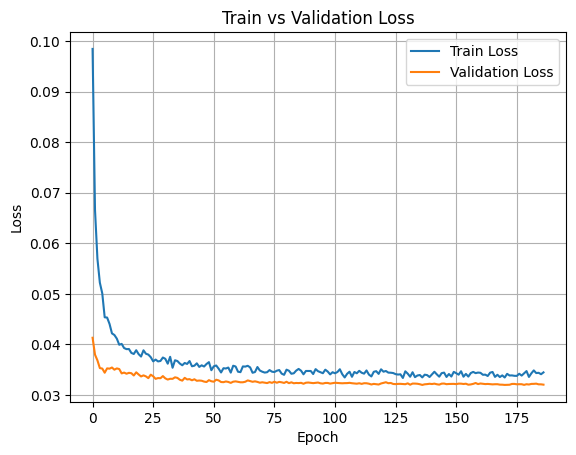

In [80]:
df = pd.read_csv("datos/Resilience_CleanOnly_v1_PREPROCESSED_v2.csv", encoding="latin1")
sizes = [len(df.columns)-1,16,8,1]
output_activation = nn.Identity
intermediate_activation = nn.ReLU
normalize_output = True
loss = nn.MSELoss
name = f"model_{sizes}_output_{output_activation.__name__}_intermediate_{intermediate_activation.__name__}_normalized_data_{normalize_output}_loss_{loss.__name__}"

comparison_table = pd.read_csv("results/comparison_table.csv")

#probabilities = df["weight"]


weight_path = f"results/{name}.pth" if os.path.exists(f"results/{name}.pth") else None
logger = Logger("results/logs")

train_df = df.sample(frac=0.7, random_state=42)
val_df = df.drop(train_df.index)

train_data = CustomDataset(train_df, normalize_output)
val_data = CustomDataset(val_df, normalize_output)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
val_loader = DataLoader(val_data, batch_size=2, shuffle=False)

model = Model(weight_path,description=name, hidden_sizes=sizes, output_activation=output_activation, dropout_p=0.5)  
criterion = loss()
optimizer = optim.Adagrad(model.parameters(), lr=0.1)

trained_model, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, 300, logger)

torch.save(trained_model.state_dict(), f"results/{name}.pth")

new_row = {
    "name": name,
    "loss": val_loss
}

comparison_table = pd.concat([comparison_table, pd.DataFrame([new_row])], ignore_index=True)
comparison_table.to_csv("results/comparison_table.csv", index=False)